In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Step 1: Data Preprocess

In [2]:
data = pd.read_csv("train.csv", dtype = {'VisitNumber': str, 'Upc': str, 'FinelineNumber':str, 'TripType':"category" , 'Weekday':"category"})

In [3]:
#Leave out Upc
data.drop('Upc', axis = 1, inplace = True)

In [4]:
data.info() #647054 rows × 6 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 6 columns):
TripType                 647054 non-null category
VisitNumber              647054 non-null object
Weekday                  647054 non-null category
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null object
dtypes: category(2), int64(1), object(3)
memory usage: 21.0+ MB


### Missing Value

In [5]:
data.isnull().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

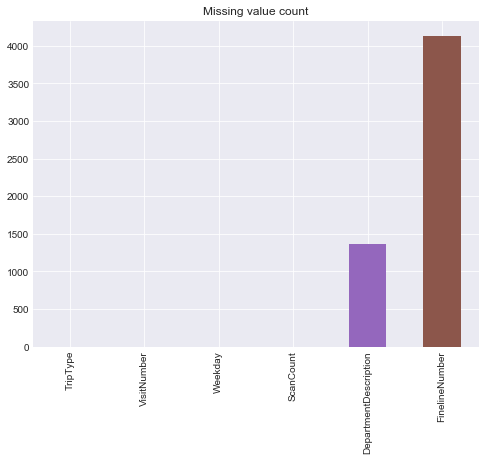

In [6]:
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
data.isnull().sum().plot.bar()
plt.title("Missing value count")
plt.show()

(array([ 6.,  0.,  0.,  1.,  0.,  0., 84.,  0.,  0., 63.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

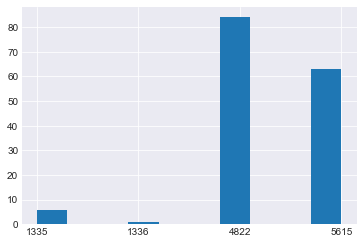

In [7]:
data[(data['DepartmentDescription'].isnull()) | (data['FinelineNumber'].isnull())] #4129 rows
pharmacy_null = data[((data['FinelineNumber'].isnull())) & (data['DepartmentDescription'] == 'PHARMACY RX')] #2768 rows
pharmacy_notnull = data[((data['FinelineNumber'].notnull())) & (data['DepartmentDescription'] == 'PHARMACY RX')] 
plt.hist(pharmacy_notnull['FinelineNumber'])

In [8]:
#Deal with missing FinelineNumber in 'PHARMACY RX' with replacement of '9999'
phar_missing_index = list(data[(data['DepartmentDescription'] == 'PHARMACY RX') & (data['FinelineNumber'].isnull())].index)
for i in phar_missing_index:
    data["FinelineNumber"].iloc[i] = "9999"

In [9]:
data.dropna(inplace = True) 
data.drop('TripType', axis = 1, inplace = True)

In [10]:
data.shape #(645693, 5)

(645693, 5)

In [11]:
data['ScanCount'].unique()

array([ -1,   1,   2,   3,   5,   6,   4,  14,  -2,   9,   7,  10,   8,
        -3,  -5,  11,  16,  -4,  13,  15,  30,  12,  20,  -6, -12,  19,
        46,  23,  -7,  22,  25,  24,  31,  -9,  51,  17,  18,  71, -10],
      dtype=int64)

### Spreading features

#### 1. FinelineNumber

In [12]:
data['VisitNumber'] = data['VisitNumber'].astype(int, copy=False)

In [13]:
len(data['VisitNumber'].unique())

95516

In [14]:
group_visit_fineline = data.groupby(['VisitNumber','FinelineNumber']).agg({'FinelineNumber':'count'})

In [15]:
fn = group_visit_fineline.unstack() 

In [16]:
fn = fn['FinelineNumber']
fn.fillna(0, inplace= True)

In [17]:
#finelineNumber columns
fn_seq = list(fn.columns)

In [18]:
X = np.array(fn) #(95516, 5196)

In [19]:
#X[X > 0] = 1

#### 2. Weekday

In [20]:
day = pd.get_dummies(data[["VisitNumber", "Weekday"]], columns = ["Weekday"])
day = day.drop_duplicates()

In [21]:
day.drop('VisitNumber', axis = 1, inplace = True)

In [22]:
day.head()
day = day[['Weekday_Sunday', 'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday']]

In [23]:
X_day = np.array(day)

In [24]:
temp = np.concatenate((X, X_day), axis=1)

In [25]:
temp.shape

(95516, 5203)

#### 3. DepartmentDescription

In [26]:
dept = data.groupby(['VisitNumber','DepartmentDescription']).agg({'DepartmentDescription':'count'})
dept = dept.unstack()
dept = dept['DepartmentDescription']
dept.fillna(0, inplace= True)

In [27]:
department = np.array(dept) 
#department[department > 0] = 1

In [28]:
final = np.concatenate((temp, department), axis=1) #(95516, 5271)

In [29]:
final = final.astype(np.float32, copy=False)

In [30]:
final.shape

(95516, 5271)

#### 4. ScanCount

In [31]:
sc = data.groupby(['VisitNumber'], as_index = False).agg({'ScanCount':'sum'})

In [32]:
def scanlevel(row):
    if row <0 :
        return 'return'
    elif row<5:
        return "few"
    elif row <15:
        return "medium"
    else:
        return "many"

In [33]:
sc["sc_level"] = sc["ScanCount"].apply(scanlevel)

In [34]:
sc.head()

,VisitNumber,ScanCount,sc_level
0,5,-1,return
1,7,2,few
2,8,27,many
3,9,3,few
4,10,3,few


In [35]:
sc_dummy = pd.get_dummies(sc[["VisitNumber", "sc_level"]], columns = ["sc_level"])

In [37]:
sc_dummy = sc_dummy[["VisitNumber", 'sc_level_return','sc_level_few','sc_level_medium','sc_level_many']]

In [38]:
sc_dummy.drop("VisitNumber", axis =1, inplace = True)

In [39]:
sc_array = np.array(sc_dummy)

In [40]:
df = np.concatenate((final, sc_array), axis=1)

In [41]:
df.shape

(95516, 5275)

In [43]:
np.savetxt("df_preprocess.csv", df, delimiter = ",")

In [45]:
from scipy import sparse
df_sparse = sparse.csr_matrix(df)

In [47]:
import scipy.sparse
# Save a sparse matrix to a file 
# source:https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.save_npz.html
scipy.sparse.save_npz('df_sparse_matrix.npz', df_sparse)

In [50]:
# read sparse matrix
# test = sparse_matrix = scipy.sparse.load_npz('df_sparse_matrix.npz')
# test.todense()